In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

import scipy.stats as scs

# A model of prices

Consider the following simple model for how the price of an asset can change over time. At time 0, the prices is $P_0$. Over the next period of time, the price can either increase or decrease by a fixed amount $\Delta$. The probabilities of the increase or decrease are, respectively, $\pi$ and $1-\pi$.

```{figure} images/Binomial_1.png
:name: binomial-fig-1
:width: 275px
:align: center


One-period Binomial model.
```

It's easy to extend this model to allow for additional time intervals. After three intervals, we have:

```{figure} images/Binomial_2.png
:name: binomial-fig-2
:width: 750px
:align: center

Binomial model with 3 time periods.
```

After three intervals there are four possible outcomes:

- The price is $P_0 + 3\Delta$. There is one path leading to this outcome: in every interval the price follows the high path, so this happens with probability $\pi^3$.
- The price is $P_0 +\Delta$. There are three paths that lead to this outcome: a combination of two up moves and one down move. The probability of following each one of these paths is $\pi^2(1-\pi)$.
- The price is $P_0 -\Delta$. Again, there are three paths leading to this outcome: any combination of one up move and two down moves, each of which has probability of $\pi(1-\pi)^2$.
 - The price is $P_0 -3\Delta$, which happens only if the price moves down in every period, implying a probability of $(1-\pi)^3$.

In general, after $n$ periods, there will be $n+1$ nodes. The number of paths to the $k$th terminal node (where we begin labelling the bottom node as "0") is given by the *binomial coefficient*,

$$\binom {n}{k} = \frac{n!}{k!(n-k)!}, \quad k\in\{0, 1, \ldots, n\}.$$

The number of paths to the terminal nodes for varying values of $n$ is shown below.

In [2]:
from scipy.special import binom

for n in [1, 3, 5, 10, 25]:
    print('{}:\t{}'.format(n, [int(binom(n, k)) for k in range(n+1)]))

1:	[1, 1]
3:	[1, 3, 3, 1]
5:	[1, 5, 10, 10, 5, 1]
10:	[1, 10, 45, 120, 210, 252, 210, 120, 45, 10, 1]
25:	[1, 25, 300, 2300, 12650, 53130, 177100, 480700, 1081575, 2042975, 3268760, 4457400, 5200300, 5200300, 4457400, 3268760, 2042975, 1081575, 480700, 177100, 53130, 12650, 2300, 300, 25, 1]


The probability of arriving at node $k$ is therefore

$$
\P(k) = {\binom {n}{k}}\pi^{k}(1-\pi)^{n-k}, \quad k=0,1,2,\ldots,n.
$$ (binom_prob)

:::{margin}
Note that by defining `k` as a numpy array we are able to calculate the vector of all probabilities in a single line of code with no loop.
:::

For example, setting $\pi=0.5$, the probabilities associated with the four nodes in {numref}`binomial-fig-2` are:

In [3]:
π = 0.5
n = 3
k = np.arange(n+1)

binom(3, k) * π**k * (1-π)**(n-k)

array([0.125, 0.375, 0.375, 0.125])

This function in equation {eq}`binom_prob` is called the *probability mass function* (PMF) for a *binomial distribution*. It gives the probability for each possible outcome of the *random variable* $k$.

Rather than calculate the probability manually, we can call the `pmf` method from the SciPy `stats` [library](https://docs.scipy.org/doc/scipy/reference/stats.html):

In [4]:
scs.binom.pmf(k, n, π)

array([0.125, 0.375, 0.375, 0.125])

```{warning}
Note that we are using two different functions called `binom` here. The first is `scipy.special.binom` which we imported and refer to as `binom`; this gives the binomial coefficent. The second is `scipy.stats.binom`, which is a class for calculating properties of the binomial distribution. While the two are related, they are conceptually distinct.
```

The price at terminal node $k$ is

$$P_n = P_0 + (2k-n)\Delta.$$

For technical reasons, it is necessary to make $\Delta$ depend on $\pi$. Specifically, we set

$$\Delta = \sqrt{\pi(1-\pi)}.$$

:::{admonition} Extra credit
:class: admonition-extra-credit, dropdown

In a standard binomial model, the price at each step can go up by $u$ or down by $d$, so after one period the price is either $S_0 u$ or $S_0 d.$ In the model above, we're assuming that we have log-prices, so we add the price changes rather than multiplying.

{cite:ts}`cox1979option` show that, for a tree to lead to a stock price with variance $\sigma^2$, it must be that

$$u = e^{\sigma\sqrt{T/n}}.$$

In our model, $\Delta = \ln(u)$, so

$$\Delta = \sigma\sqrt{T/n}.$$

Now, it can be shown that, in the limit, a binomial distribution converges to a Normal distribution with a mean of $n\pi$ and variance of $n\pi(1-\pi)$:

$$\frac{k-n\pi}{\sqrt{n\pi(1-\pi)}} \sim N(0,1).$$

Therefore, 

$$\sigma = \sqrt{n\pi(1-\pi)}$$

and

$$\Delta = \sqrt{\pi(1-\pi)T}.$$

For simplification, we are assuming that $T=1$.
:::

Using the 3-period model from above, the table below shows for each node:

- the number of "up" moves;
- the number of "down" moves;
- the net number of steps, $\Delta$;
- the number of possible paths leading to the node;
- the price at that node; and
- the probability of arriving at that node.

We assume that $P_0=50$. With $\pi=0.5$, we have $\Delta=0.5$.

In [13]:
P0 = 50

def make_paths(n, π=0.5):
    Δ = np.sqrt(π*(1-π))
    k = np.arange(n+1)
    
    paths = pd.DataFrame({'n_up': k,
                          'n_down': n - k,
                          'Δs': 2*k - n,
                          'paths': binom(n, np.arange(0,n+1))})
    paths['price'] = P0 + Δ * paths['Δs'] 
    paths['prob'] = scs.binom.pmf(np.arange(0,n+1), n, π)
    
    paths['paths'] = pd.to_numeric(paths['paths'], downcast='integer')
    paths.index.name = 'node'
    return(paths)

make_paths(3)

,n_up,n_down,Δs,paths,price,prob
node,,,,,,
0,0,3,-3,1,48.5,0.125
1,1,2,-1,3,49.5,0.375
2,2,1,1,3,50.5,0.375
3,3,0,3,1,51.5,0.125


Extending the model to 15 steps, we have:

In [16]:
paths = make_paths(15)
paths

,n_up,n_down,Δs,paths,price,prob
node,,,,,,
0,0,15,-15,1,42.5,0.000031
1,1,14,-13,15,43.5,0.000458
2,2,13,-11,105,44.5,0.003204
3,3,12,-9,455,45.5,0.013885
4,4,11,-7,1365,46.5,0.041656
5,5,10,-5,3003,47.5,0.091644
6,6,9,-3,5005,48.5,0.152740
7,7,8,-1,6435,49.5,0.196381
8,8,7,1,6435,50.5,0.196381


The *expected value* of $P_n$ is the probability-weighted sum of all possible prices at time $n$,

$$\E(P_n) = \sum_{k=0}^n \pi_k P^{(k)},$$

where $P^{(k)}$ gives the price at terminal node $k$. The expected value is often denoted by the Greek letter $\mu$ (“mu”).

In [6]:
μ = (paths['prob'] * paths['price']).sum()

μ

50.000000000000014

Notice that the expected value is not a possible outcome: there is no path that ends with a price of 50. So while the mean might be one of the possible outcomes, there's not guarantee that it will be.

Closely related to the expected value is the *variance* of $P_n$. This is the probability-weighted sum of the squares of the difference between the price at each node and the expected value of $P_n$:

$$\var(P_n) = \sum_{k=0}^n \pi_k \left(P^{(k)}-\E(P_n)\right)^2.$$

Variance is often denoted by $\sigma^2$ ("sigma-squared").

In [7]:
(paths['prob'] * (paths['price'] - μ)**2).sum()

3.749999999999999

The *standard deviation* is the square root of the variance, and therefore denoted by $\sigma$.

In [8]:
def ms(paths):
    '''Calculate the mean and standard deviation of the terminal price'''
    μ = (paths['prob'] * paths['price']).sum()
    return μ, np.sqrt((paths['prob'] * (paths['price'] - μ)**2).sum())

In [9]:
ms(paths)

(50.000000000000014, 1.9364916731037083)

Consider how the distribution of possible outcomes changes as we increase the number of time steps.

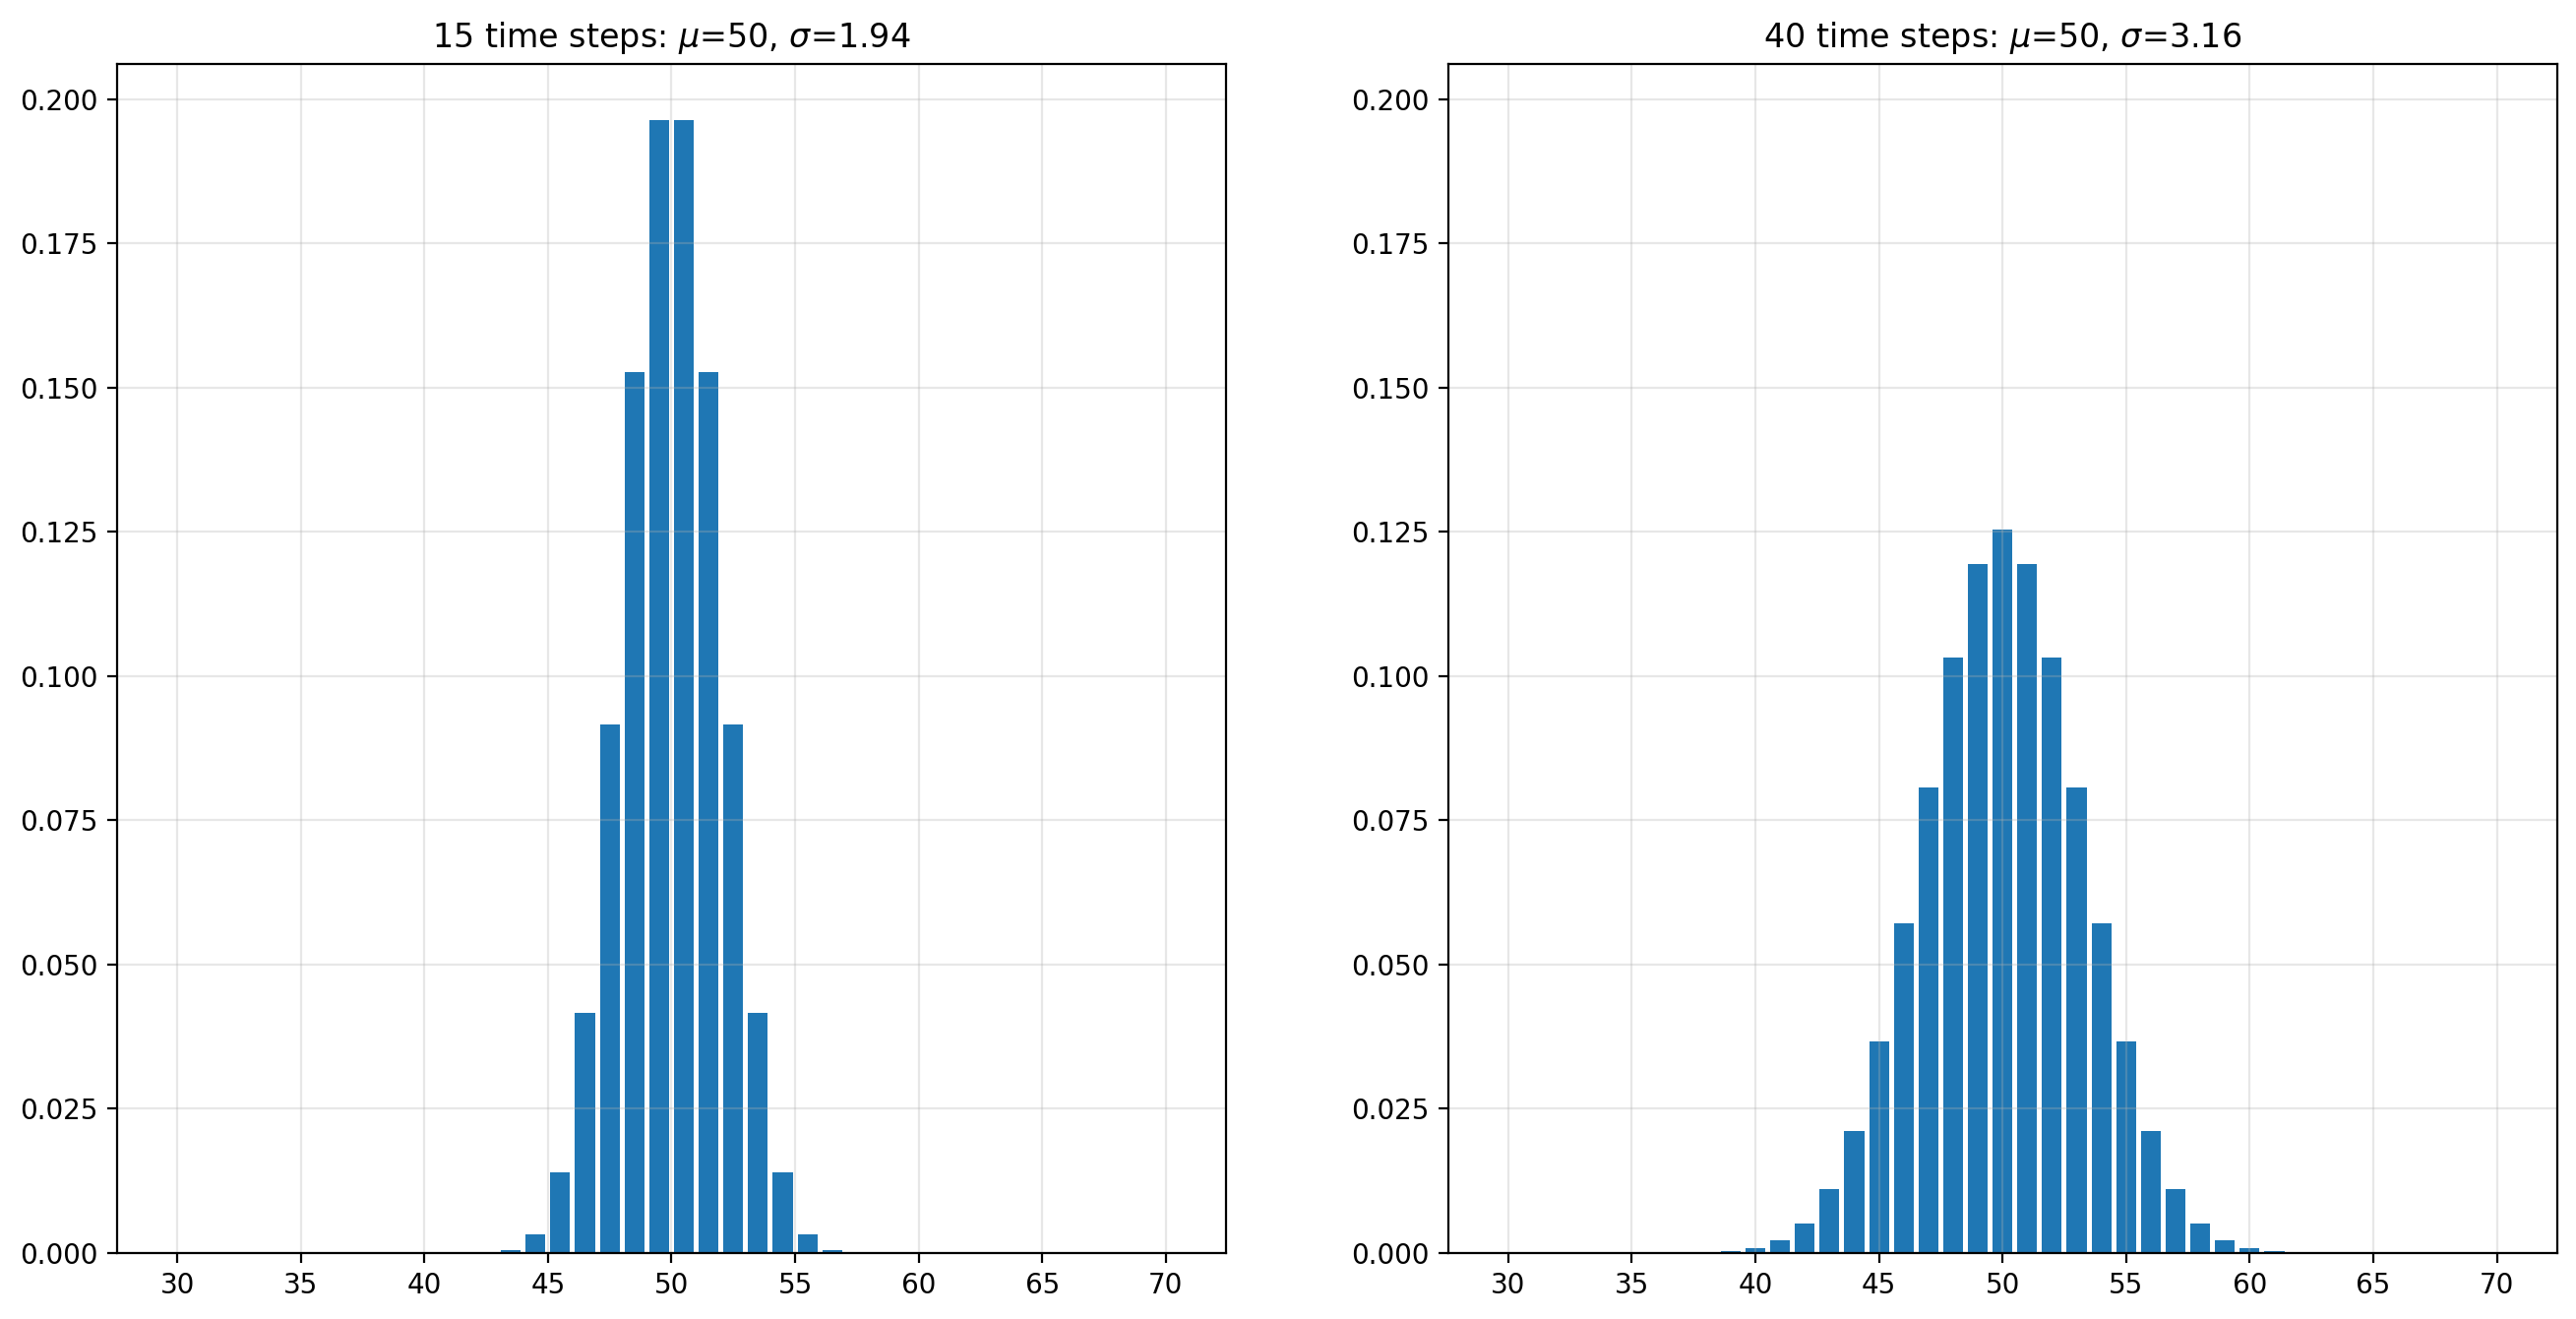

In [10]:
def paths_dist(n, ax):
    paths = make_paths(n)
    ax.bar(paths['price'], paths['prob'], align='center')
    ax.set_title('{} time steps: $\mu$={:.0f}, $\sigma$={:.2f}'.format(n, *ms(paths)))
    return ax

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

paths_dist(15, ax1)
paths_dist(40, ax2)

ax1.set_xlim(ax2.get_xlim())
ax2.set_ylim(ax1.get_ylim())

ax1.grid(alpha=0.3)
ax2.grid(alpha=0.3)

plt.show()

:::{admonition} Exercise

What happens to this distribution when we change the probability, $\pi$?
:::

There are $2^n$ paths that a price can take over $n$ time steps. For example, with $n=25$ there are over 33.5 million paths.

In [29]:
n = 25
npaths = sum(binom(n, np.arange(n+1)))
print('{:,.0f}'.format(npaths))

33,554,432


While the code below isn't a formal proof, it should convince you that

$$\sum_{k=0}^n \binom{n}{k} = 2^n.$$

In [18]:
for n in [5, 10, 25, 50, 100]:
    assert 2**n == sum(binom(n, np.arange(n+1)))

:::{admonition} Exercise

Suppose we model each week of a year as being a single time step. How many possible paths are there to the terminal nodes?
:::

:::{admonition} Solution
:class: admonition-solution, dropdown


With $n=52$ there are over 4.5 quadrillion paths:

```python
n = 52
print('{:,.0f}'.format(2**n))
```

```md
4,503,599,627,370,496
```

:::